# Ordinal Regression of Outcomes Categorical variable

In [174]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, \
    LinearKernel, ProductKernel, MaternKernel, SpectralMixtureKernel

import tqdm

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0,"..")

# from modules.HetMOGP import HetMOGP
from modules.additive_hmogp import HetMOGP
from modules.metrics import scotts_pi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# from numpyro.infer.reparam import TransformReparam
# from numpyro import handlers
# from numpyro.distributions import (
#     Dirichlet,
#     TransformedDistribution,
#     transforms,
# )
# import numpyro



# from typing import Optional, Union
# import torch
# import gpytorch
# import pyro
# import pyro.distributions as dist
# from torch.distributions import constraints

# from linear_operator.operators.dense_linear_operator import DenseLinearOperator
# from linear_operator.operators import KroneckerProductLinearOperator, RootLinearOperator
# from linear_operator.utils.interpolation import left_interp

# from gpytorch import settings
# from gpytorch.distributions import MultitaskMultivariateNormal, MultivariateNormal
# from gpytorch.module import Module
# from gpytorch.variational._variational_strategy import _VariationalStrategy

# class LMCSeparableKernel(gpytorch.kernels.Kernel):
#     # Stores each vector in covar_x to plot ILFs / LPFs
#     # Allows for additive kernels
    
#     def __init__(self, kernel_list, active_dims__, **kwargs):
        
#         super(LMCSeparableKernel, self).__init__(**kwargs)
#         self.kernel_modules = torch.nn.ModuleList(kernel_list)
#         self.active_dims_ = None
#         if active_dims__ is not None:
#             self.active_dims_ = torch.asarray(active_dims__, dtype=torch.long)
    
#     def forward(self, x1, x2, **params):
        
#         x1_, x2_ = x1, x2
#         i = 0
#         if self.active_dims_ is not None:
#             for d in self.active_dims_:
#                 x1_ = x1[...,d]
#                 if x2 is not None:
#                     x2_ = x2[...,d]
#                 if i == 0:
#                     covar_x = self.kernel_modules[i].forward(x1_, x2_, **params)                 
#                 else:
#                     add_covar_x = self.kernel_modules[i].forward(x1_, x2_, **params)
#                     if not isinstance(add_covar_x, torch.Tensor):
#                         add_covar_x = add_covar_x.to_dense()
#                     covar_x = torch.concatenate([covar_x, add_covar_x])
#                     # covar_x = torch.vstack([covar_x, add_covar_x])
#                 i += 1
#         else:
#             if i == 0:
#                 covar_x = self.kernel_modules[i].forward(x1_, x2_, **params)                 
#             else:
#                 add_covar_x = self.kernel_modules[i].forward(x1_, x2_, **params)
#                 if not isinstance(add_covar_x, torch.Tensor):
#                     add_covar_x = add_covar_x.to_dense()
#                 covar_x = torch.concatenate([covar_x, add_covar_x])
#             i += 1
#         return covar_x

# def _select_lmc_coefficients(lmc_coefficients: torch.Tensor, indices: torch.LongTensor) -> torch.Tensor:
#     """
#     Given a list of indices for ... x N datapoints,
#       select the row from lmc_coefficient that corresponds to each datapoint
#     lmc_coefficients: torch.Tensor ... x num_latents x ... x num_tasks
#     indices: torch.Tesnor ... x N
#     """
    
#     batch_shape = torch.broadcast_shapes(lmc_coefficients.shape[:-1], indices.shape[:-1])

#     # We will use the left_interp helper to do the indexing
#     lmc_coefficients = lmc_coefficients.expand(*batch_shape, lmc_coefficients.shape[-1])[..., None]
#     indices = indices.expand(*batch_shape, indices.shape[-1])[..., None]
#     res = left_interp(
#         indices,
#         torch.ones(indices.shape, dtype=torch.long, device=indices.device),
#         lmc_coefficients,
#     ).squeeze(-1)
#     return res


# class LMCVariationalStrategy(_VariationalStrategy):

#     def __init__(
#         self,
#         base_variational_strategy: _VariationalStrategy,
#         num_tasks: int,
#         num_latents: int = 1,
#         latent_dim: int = -1,
#         jitter_val: Optional[float] = None,
#     ):
#         Module.__init__(self)
#         self.base_variational_strategy = base_variational_strategy
#         self.num_tasks = num_tasks
#         batch_shape = self.base_variational_strategy._variational_distribution.batch_shape
        
#         # Added
#         self.latent_dist = None

#         # Check if no functions
#         if latent_dim >= 0:
#             raise RuntimeError(f"latent_dim must be a negative indexed batch dimension: got {latent_dim}.")
#         if not (batch_shape[latent_dim] == num_latents or batch_shape[latent_dim] == 1):
#             raise RuntimeError(
#                 f"Mismatch in num_latents: got a variational distribution of batch shape {batch_shape}, "
#                 f"expected the function dim {latent_dim} to be {num_latents}."
#             )
#         self.num_latents = num_latents
#         self.latent_dim = latent_dim

#         # Make the batch_shape
#         self.batch_shape = list(batch_shape)
#         del self.batch_shape[self.latent_dim]
#         self.batch_shape = torch.Size(self.batch_shape)

#         # LCM coefficients
#         lmc_coefficients = torch.randn(*batch_shape, self.num_tasks)
#         self.register_parameter("lmc_coefficients", torch.nn.Parameter(lmc_coefficients))

#         if jitter_val is None:
#             self.jitter_val = settings.variational_cholesky_jitter.value(
#                 self.base_variational_strategy.inducing_points.dtype
#             )
#         else:
#             self.jitter_val = jitter_val
            

#     @property
#     def prior_distribution(self) -> MultivariateNormal:
#         return self.base_variational_strategy.prior_distribution

#     @property
#     def variational_distribution(self) -> MultivariateNormal:
#         return self.base_variational_strategy.variational_distribution

#     @property
#     def variational_params_initialized(self) -> bool:
#         return self.base_variational_strategy.variational_params_initialized

#     def kl_divergence(self):
#         return super().kl_divergence().sum(dim=self.latent_dim)

#     def __call__(
#         self, x: torch.Tensor, prior: bool = False, task_indices: Optional[torch.LongTensor] = None, **kwargs
#     ) -> Union[MultitaskMultivariateNormal, MultivariateNormal]:
        
#         self.latent_dist = self.base_variational_strategy(x, prior=prior, **kwargs)
#         num_batch = len(self.latent_dist.batch_shape)
#         latent_dim = num_batch + self.latent_dim

#         if task_indices is None:
#             num_dim = num_batch + len(self.latent_dist.event_shape)

#             # Every data point will get an output for each task
#             # Therefore, we will set up the lmc_coefficients shape for a matmul
            
#             # lmc_coefficients: ... Q x num_lpf
#             lmc_coefficients = self.lmc_coefficients.expand(*self.latent_dist.batch_shape, self.lmc_coefficients.size(-1))

#             # latent_mean: ... x N x Q
#             latent_mean = self.latent_dist.mean.permute(*range(0, latent_dim), *range(latent_dim + 1, num_dim), latent_dim)
            
#             # mean: ... x N x num_lpf
#             mean = latent_mean @ lmc_coefficients.permute(
#                 *range(0, latent_dim), *range(latent_dim + 1, num_dim - 1), latent_dim, -1
#             )

#             # latent_covar: ... x Q x N x N  
#             latent_covar = self.latent_dist.lazy_covariance_matrix
            
#             # lmc_factor: ... x Q x num_lpf x num_lpf
#             lmc_factor = RootLinearOperator(lmc_coefficients.unsqueeze(-1))
            
#             # latent_kron: ... x Q x (N x num_lpf) x (N x num_lpf)
#             latent_kron = KroneckerProductLinearOperator(latent_covar, lmc_factor)
            
#             # covar: ... x (N x num_lpf) x (N x num_lpf) 
#             covar = latent_kron.sum(latent_dim)
#             # Add a bit of jitter to make the covar PD
#             covar = covar.add_jitter(self.jitter_val)

#             # Done!
#             function_dist = MultitaskMultivariateNormal(mean, covar)

#         else:            
#             lmc_coefficients = _select_lmc_coefficients(self.lmc_coefficients, task_indices)

#             # Mean: ... x N
#             mean = (self.latent_dist.mean * lmc_coefficients).sum(latent_dim)

#             # Covar: ... x N x N
#             latent_covar = self.latent_dist.lazy_covariance_matrix
#             lmc_factor = RootLinearOperator(lmc_coefficients.unsqueeze(-1))
#             covar = (latent_covar * lmc_factor).sum(latent_dim)
#             # Add a bit of jitter to make the covar PD
#             covar = covar.add_jitter(self.jitter_val)

#             # Done!
#             function_dist = MultivariateNormal(mean, covar)

#         return function_dist

# class HetMOGP(gpytorch.models.ApproximateGP):
    
#     ELBO_NORMALISER = 1000 # scales ELBO for performance
    
#     def __init__(self, train_x, num_lpf, likelihoods, kernels, active_dims=None, name_prefix="hmogp", num_inducing=100, jitter_val=1e-06, **kwargs):
        
#         self.name_prefix = name_prefix
#         self.likelihoods = likelihoods
#         self.num_latents = len(kernels)
#         self.num_lpf = num_lpf
#         self.device = train_x.device
#         self.has_ordinal = "Ordinal" in likelihoods
#         if self.has_ordinal:
#             self.nclasses = kwargs["nclasses"]

#         if train_x.dim() == 1:
#             train_x = train_x.unsqueeze(-1)
        
#         if active_dims is not None:
#             assert len(active_dims) == len(kernels), f"Size of active_dims does not much size of kernel list. \
#             len(active_dims) = {len(active_dims)}, len(kernels) = {len(kernels)}."
        
#         # Let's use a different set of inducing points for each latent function
#         inducing_points = train_x[torch.randint(0, train_x.size(0), size=(num_inducing,)),...].unsqueeze(0)

#         # We have to mark the MeanFieldVariationalDistribution as batch
#         # so that we learn a variational distribution for each task
        
#         variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(
#             inducing_points.size(-2), batch_shape=torch.Size([self.num_latents])
#         )

#         # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
#         # so that the output will be a MultitaskMultivariateNormal rather than a batch output
#         base_variational_strategy = gpytorch.variational.VariationalStrategy(
#                 self, inducing_points, 
#                 variational_distribution, # variational distribution over the inducing point values, q(u),
#                 learn_inducing_locations=True
#             )

#         variational_strategy = LMCVariationalStrategy(
#             base_variational_strategy=base_variational_strategy,
#             num_tasks=self.num_lpf,
#             num_latents=self.num_latents,
#             latent_dim=-1,
#             jitter_val=jitter_val
#         )
        
#         super().__init__(variational_strategy=variational_strategy)
        
#         # The mean and covariance modules should be marked as batch
#         # so we learn a different set of hyperparameters
#         self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([self.num_latents]))
#         self.covar_module = LMCSeparableKernel(kernels, active_dims__=active_dims, batch_shape=torch.Size([self.num_latents]))

#     def forward(self, x):
#         # The forward function should be written as if we were dealing with each output
#         # dimension in batch
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
#     def compute_likelihoods(self, y, function_dist, likelihoods, **kwargs):
        
#         y_input = y is not None
        
#         if y_input:
#             assert y.size(-1) == len(likelihoods), f"Size of output y does not much size of likelihoods list. Input size is ({y.size(-1)}, {len(likelihoods)})."
        
#         with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
#             # Sample from latent function distribution
#             f = pyro.sample(self.name_prefix + ".f(x)", function_dist)
            
#             j = 0
#             for i, l in enumerate(likelihoods):
                
#                 y_ = None
#                 if y_input:             
#                     y_ = y[...,i]
                
#                 if l == "HetGaussian":
#                     pyro.sample(
#                         self.name_prefix + ".y_" + str(i),
#                         dist.Normal(f[..., j], f[...,j+1].exp()).to_event(1),
#                         obs=y_
#                     )
#                     j += 2
#                 elif l == "Poisson":
#                     pyro.sample(
#                         self.name_prefix + ".y_" + str(i),
#                         dist.Poisson(f[...,j].exp()).to_event(1),
#                         obs=y_
#                     )
#                     j += 1
#                 elif l == "Bernoulli":
#                     pyro.sample(
#                         self.name_prefix + ".y_" + str(i),
#                         dist.Bernoulli(logits=f[...,j]).to_event(1),
#                         obs=y_
#                     )
#                     j += 1
#                 elif l == "Categorical":
#                     n_categories = y[...,i].max().to(torch.long).item() + 1
#                     pyro.sample(
#                         self.name_prefix + ".y_" + str(i),
#                         dist.Categorical(logits=f[...,j:(n_categories)]).to_event(1),
#                         obs=y_
#                     )
#                     j += n_categories
#                 elif l == "Ordinal":
#                     c_y = kwargs["cutpoints"]
#                     pyro.sample(
#                         self.name_prefix + ".y_" + str(i),
#                         dist.OrderedLogistic(f[...,j], c_y).to_event(1), 
#                         obs=y_
#                     )
#                     j += 1
                    
#             assert f.size(-1) == j, f"Not all latent parameter functions (LPF) were used as inputs to likelihood distributions. \
#                 Total LPF is {f.size(-1)}, however only {j} of the LPFs were used as inputs."
    
#     @pyro.poutine.scale(scale=1.0/ELBO_NORMALISER)
#     def guide(self, x, y):
#          # Get q(f) - variational (guide) distribution of latent function
#         function_dist = self.pyro_guide(x)
        
#         # prior for cutpoints of ordinal
#         if self.has_ordinal:
#             # Proper Prior Scenario
#             mu_init = torch.tensor(0.).expand(self.nclasses-1)
#             sd_init = torch.tensor(5.).expand(self.nclasses-1)
#             mu_cutpoints = pyro.param("mu_cutpoints", mu_init)
#             sd_cutpoints = pyro.param("sd_cutpoints", sd_init, constraint=constraints.positive)
#             # pyro.sample(
#             #         self.name_prefix + ".c_y",
#             #         dist.TransformedDistribution(
#             #             dist.Normal(mu_cutpoints, sd_cutpoints),
#             #             dist.transforms.OrderedTransform()
#             #         ),
#             #     )
            
#             # Principled prior with Dirichlet Distribution Scenario
#             concentration = torch.ones((self.nclasses,)) * 10.0
#             anchor_point=0.0
#             with handlers.reparam(config={"c_y": TransformReparam()}):
#                 c_y = pyro.sample(
#                     "c_y",
#                     TransformedDistribution(
#                         Dirichlet(concentration),
#                         transforms.SimplexToOrderedTransform(anchor_point),
#                     ),
#                 )
        
#         with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
#             # Sample from latent function distribution
#             f = pyro.sample(self.name_prefix + ".f(x)", function_dist)
        
#     @pyro.poutine.scale(scale=1.0/ELBO_NORMALISER)
#     def model(self, x, y):
#         pyro.module(self.name_prefix + ".gp", self)
        
#         # prior for cutpoints of ordinal
#         if self.has_ordinal:
#             # Proper Prior Scenario
#             # c_y = pyro.sample(
#             #         self.name_prefix + ".c_y",
#             #         TransformedDistribution(
#             #             dist.Normal(0., 5.).expand([self.nclasses - 1]), 
#             #             dist.transforms.OrderedTransform()
#             #         ),
#             #     )
            
#             # Principled prior with Dirichlet Distribution Scenario
#             concentration = torch.ones((self.nclasses,)) * 10.0
#             anchor_point=0.0
#             with handlers.reparam(config={"c_y": TransformReparam()}):
#                 c_y = pyro.sample(
#                     "c_y",
#                     TransformedDistribution(
#                         Dirichlet(concentration),
#                         transforms.SimplexToOrderedTransform(anchor_point),
#                     ),
#                 )
            
#         # Get p(f) - prior distribution of latent function
#         function_dist = self.pyro_model(x)        
#         self.compute_likelihoods(y, function_dist, self.likelihoods, cutpoints=c_y)
        

Data transform and EDA

In [4]:
df = pd.read_csv('msl_evasion-003.csv')

# We remove MUTUAL_KILL and keep the variables ordered as:
# VIPER_WIN = 2
# BOTH_SURVIVED = 1
# COBRA_WIN = 0

outcome_map = {
    "VIPER_WIN": 2,
    "BOTH_SURVIVED": 1,
    "COBRA_WIN": 0,
}

df = df[df.outcome != "MUTUAL_KILL"]
df.outcome = df.outcome.map(outcome_map)

log_standardise = lambda x: (np.log(x) - np.mean(np.log(x))) / np.std(np.log(x))
log_norm = lambda x: (np.log(x) - np.min(np.log(x))) / (np.max(np.log(x)) - np.min(np.log(x)))
norm = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

def norm_custom(x, minval, maxval):
    x = (x - minval) / (maxval - minval)
    return x

# log normalise data
df["lognorm_viper_launch_range"] = df.viper_launch_range.pipe(log_norm)
df["lognorm_viper_briefed_launch_range"] = df.viper_briefed_launch_range.pipe(log_norm)
df["lognorm_viper_briefed_evasion_range"] = df.viper_briefed_evasion_range.pipe(log_norm)
df["lognorm_cobra_launch_range"] = df.cobra_launch_range.pipe(log_norm)
df["lognorm_cobra_briefed_launch_range"] = df.cobra_briefed_launch_range.pipe(log_norm)
df["lognorm_cobra_briefed_evasion_range"] = df.cobra_briefed_evasion_range.pipe(log_norm)

# normalise data
df["norm_viper_launch_range"] = df.viper_launch_range.pipe(norm)
df["norm_viper_briefed_launch_range"] = df.viper_briefed_launch_range.pipe(norm)
df["norm_viper_briefed_evasion_range"] = df.viper_briefed_evasion_range.pipe(norm)
df["norm_cobra_launch_range"] = df.cobra_launch_range.pipe(norm)
df["norm_cobra_briefed_launch_range"] = df.cobra_briefed_launch_range.pipe(norm)
df["norm_cobra_briefed_evasion_range"] = df.cobra_briefed_evasion_range.pipe(norm)

# compute min, max vals among both cobra and viper
evasion_minval = pd.concat([df.cobra_briefed_evasion_range, df.viper_briefed_evasion_range]).min()
evasion_maxval = pd.concat([df.cobra_briefed_evasion_range, df.viper_briefed_evasion_range]).max()
launch_minval = pd.concat([df.cobra_launch_range, df.viper_launch_range]).min()
launch_maxval = pd.concat([df.cobra_launch_range, df.viper_launch_range]).max()
briefed_launch_minval = pd.concat([df.cobra_briefed_launch_range, df.viper_briefed_launch_range]).min()
briefed_launch_maxval = pd.concat([df.cobra_briefed_launch_range, df.viper_briefed_launch_range]).max()

# difference between evasion and launch. normalised
df["briefed_evasion_range_diff"] = df.viper_briefed_evasion_range.apply(lambda x: norm_custom(x, evasion_minval, evasion_maxval)) - df.cobra_briefed_evasion_range.apply(lambda x: norm_custom(x, evasion_minval, evasion_maxval))
df["launch_range_diff"] = df.viper_launch_range.apply(lambda x: norm_custom(x, launch_minval, launch_maxval)) - df.cobra_launch_range.apply(lambda x: norm_custom(x, launch_minval, launch_maxval))
df["briefed_launch_range_diff"] = df.viper_briefed_launch_range.apply(lambda x: norm_custom(x, briefed_launch_minval, briefed_launch_maxval)) - df.cobra_briefed_launch_range.apply(lambda x: norm_custom(x, briefed_launch_minval, briefed_launch_maxval))

# difference between time launched
df["time_at_launch_diff"] = df.viper_time_at_launch - df.cobra_time_at_launch


<Axes: xlabel='time_at_launch_diff', ylabel='briefed_launch_range_diff'>

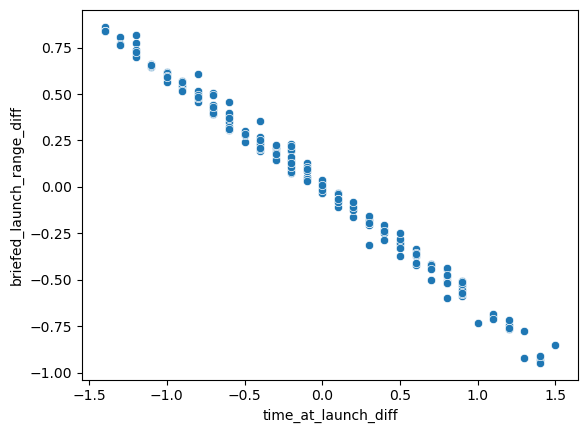

In [5]:
# when viper launches first, viper typically has a longer briefed launch range
sns.scatterplot(x=df.time_at_launch_diff, y=df.briefed_launch_range_diff)

<Axes: xlabel='time_at_launch_diff', ylabel='launch_range_diff'>

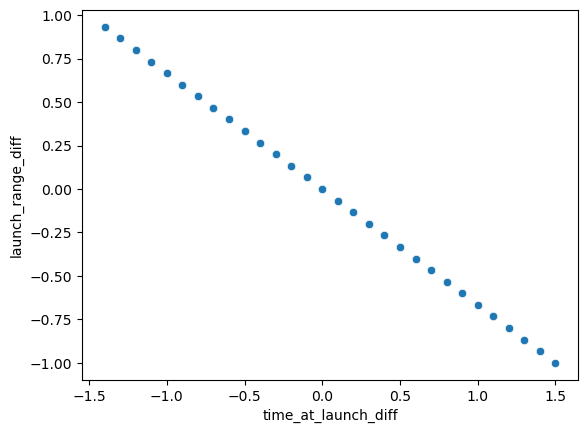

In [6]:
# when viper launches first, viper has a longer launch range
sns.scatterplot(x=df.time_at_launch_diff, y=df.launch_range_diff)

<Axes: xlabel='time_at_launch_diff', ylabel='Density'>

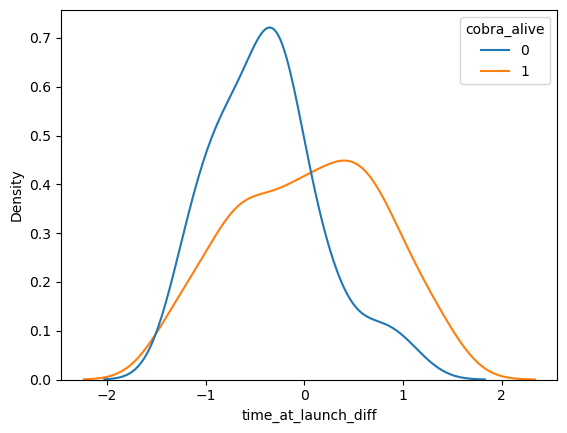

In [7]:
sns.kdeplot(x=df.time_at_launch_diff, hue=df.cobra_alive, common_norm=False)

<Axes: xlabel='briefed_evasion_range_diff', ylabel='launch_range_diff'>

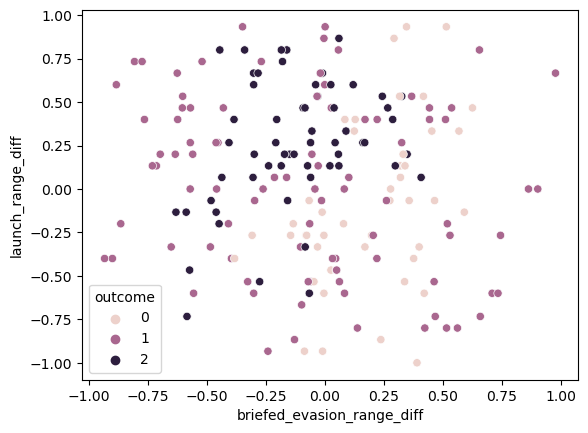

In [8]:
# longer launch range and shorter evasion range more advantageous for viper?
sns.scatterplot(x=df.briefed_evasion_range_diff, y=df.launch_range_diff, hue=df.outcome)

<Axes: xlabel='viper_time_at_launch', ylabel='Density'>

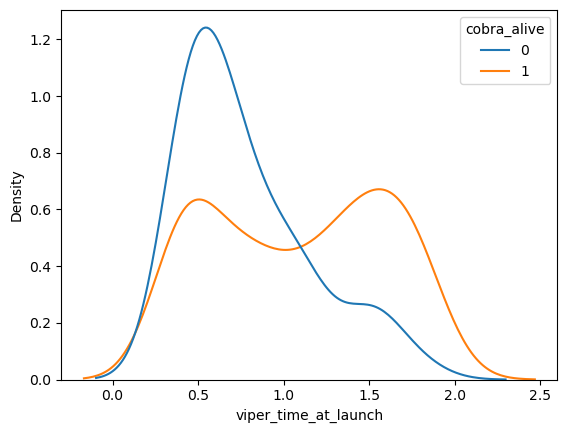

In [9]:
sns.kdeplot(x=df.viper_time_at_launch, hue=df.cobra_alive, common_norm=False)

<Axes: xlabel='cobra_time_at_launch', ylabel='Density'>

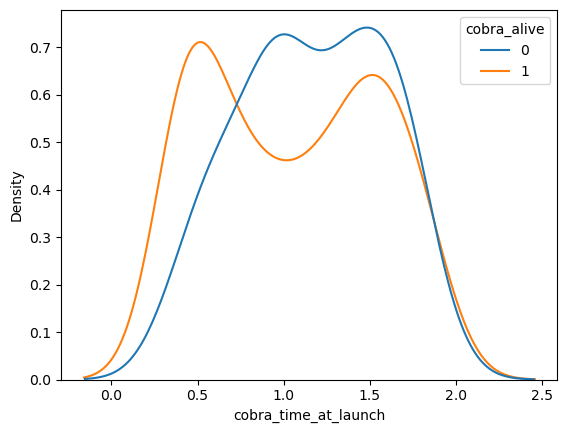

In [10]:
sns.kdeplot(x=df.cobra_time_at_launch, hue=df.cobra_alive, common_norm=False)

<Axes: xlabel='lognorm_viper_launch_range', ylabel='Density'>

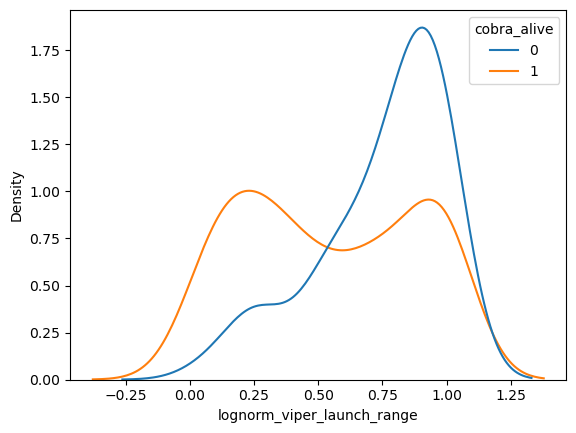

In [158]:
sns.kdeplot(x=df.lognorm_viper_launch_range, hue=df.cobra_alive, common_norm=False)

<Axes: xlabel='lognorm_cobra_launch_range', ylabel='Density'>

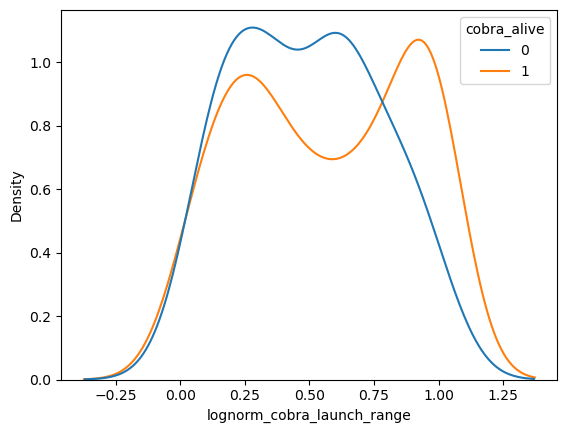

In [12]:
sns.kdeplot(x=df.lognorm_cobra_launch_range, hue=df.cobra_alive, common_norm=False)

<Axes: xlabel='lognorm_viper_briefed_evasion_range', ylabel='Density'>

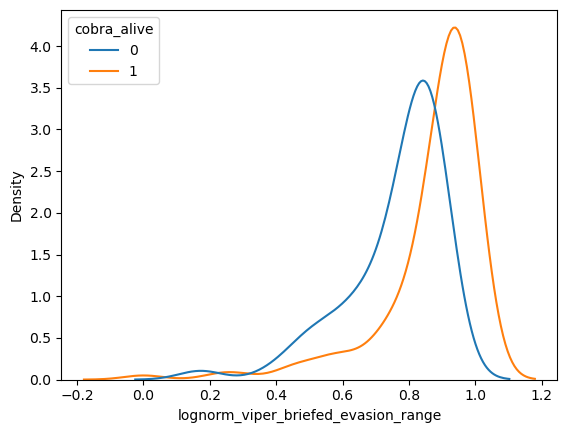

In [13]:
sns.kdeplot(x=df.lognorm_viper_briefed_evasion_range, hue=df.cobra_alive, common_norm=False)

<Axes: xlabel='lognorm_cobra_briefed_evasion_range', ylabel='Density'>

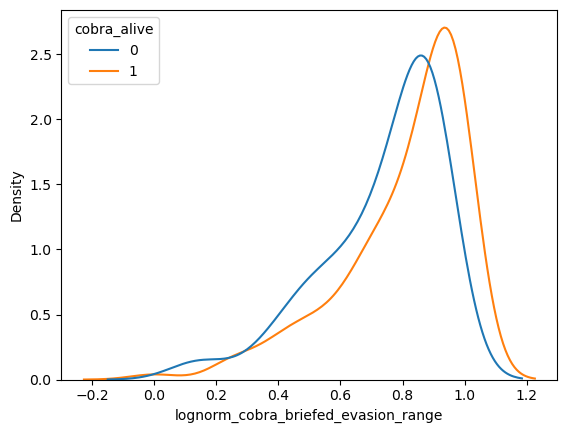

In [14]:
sns.kdeplot(x=df.lognorm_cobra_briefed_evasion_range, hue=df.cobra_alive, common_norm=False)

Setup train, test dataset

In [15]:
input_set1 = [
    "lognorm_viper_launch_range",
    "lognorm_viper_briefed_evasion_range",
    "lognorm_cobra_launch_range",
    "lognorm_cobra_briefed_evasion_range",
]

input_set2 = [
    "norm_viper_launch_range",
    "norm_viper_briefed_evasion_range",
    "norm_cobra_launch_range",
    "norm_cobra_briefed_evasion_range",
]

input_set3 = [
    "launch_range_diff",
    "briefed_evasion_range_diff",
]

input_set4 = [
    "briefed_launch_range_diff",
    "briefed_evasion_range_diff",
]

input_set5 = [
    "lognorm_viper_briefed_launch_range",
    "lognorm_viper_briefed_evasion_range",
    "lognorm_cobra_briefed_launch_range",
    "lognorm_cobra_briefed_evasion_range",
]

outcome = [
    "outcome"
]

X = torch.tensor(df[input_set2].values, dtype=torch.float)
idx_outcome, outcomes = pd.factorize(df.outcome)
y = torch.tensor(df.outcome.values, dtype=torch.long).unsqueeze(-1)

In [16]:
# redo this so the min, max values are in the training set for each dim
# manual_seed = 99

train_idx, test_idx = torch.utils.data.random_split(X, [.8, .2], \
    generator=torch.Generator().manual_seed(99))
train_idx, test_idx = train_idx.indices, test_idx.indices

train_x = X[train_idx,:]
test_x = X[test_idx,:]
train_y = y[train_idx,:]
test_y = y[test_idx,:]

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

In [130]:
input_dims = train_x.size(-1)
kernel_per_input = 2
active_dims = []

for i in range(input_dims):
    for j in range(1):
        for k in range(kernel_per_input):
            active_dims.append([i])

n_kernels = len(active_dims)
print("number of kernels =", n_kernels)

number of kernels = 8


# Fit the model

In [131]:
gamma_mean = 1.
gamma_std = .3
alpha = gamma_mean**2 / np.sqrt(gamma_std)
beta = gamma_mean / np.sqrt(gamma_std)
lengthscale_prior = gpytorch.priors.GammaPrior(alpha, beta)

batch_shape=torch.Size([1])
kernels = [
    ScaleKernel(RBFKernel(batch_shape=batch_shape, 
                                 lengthscale_prior=lengthscale_prior), 
                       batch_shape=batch_shape), 
    ScaleKernel(MaternKernel(nu=3/2, batch_shape=batch_shape, 
                                 lengthscale_prior=lengthscale_prior), 
                    batch_shape=batch_shape)
] * (input_dims)

likelihoods = ["Ordinal"]

model = HetMOGP(train_x, num_lpf=1, likelihoods=likelihoods, kernels=kernels, active_dims=active_dims, num_inducing=100, jitter_val = 1e-3, nclasses=3)

if torch.cuda.is_available():
    model = model.cuda()

In [132]:
pyro.clear_param_store()

# num_iter = 2000
num_iter = 1000 # for actual training
# num_iter = 500 # for testing if the code works
num_particles = 10

# If getting Matrix not PSD error try:
# - decreasing gamma = 1e-3 / decreasing final_lr = 1e-3 or lower (for fast training, try final_lr = 1e-2)
# - decreasing num_iter
# - tightening the lengthscale prior or kernel parameters

initial_lr = 1e-1
final_lr = 1e-7
gamma = final_lr / initial_lr  # final learning rate will be gamma * initial_l|r
lrd = gamma ** (1 / num_iter) # learning rate decay

optimizer = pyro.optim.ClippedAdam({
    'lr': initial_lr, 
    'lrd': lrd,
    'betas': (0.95, 0.999)})
    
elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

model.train()
iterator = tqdm.notebook.tqdm(range(num_iter), desc="Epoch")
loss_array = np.zeros(num_iter)
for i in iterator:
    model.zero_grad()
    loss = svi.step(x=train_x, y=train_y)
    loss_array[i] = loss
    iterator.set_postfix(loss=loss)
    
# for SE * Matern kernel, loss approx 0.95

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

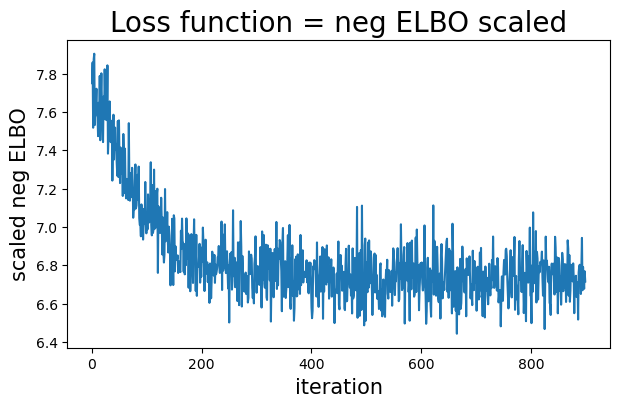

In [133]:
fig, ax = plt.subplots(figsize=(7,4))
loss_start = 100
ax.plot(np.arange(0, len(loss_array) - loss_start), loss_array[loss_start:])
ax.set_xlabel(r"iteration", fontdict={'fontsize':15})
ax.set_ylabel(r"scaled neg ELBO", fontdict={'fontsize':15})
ax.set_title(r"Loss function = neg ELBO scaled", fontsize=20);

In [134]:
raw_mu_cutpoints = pyro.get_param_store()['mu_cutpoints'].detach()
raw_sd_cutpoints = pyro.get_param_store()['sd_cutpoints'].detach()

cutpoints_dist = dist.TransformedDistribution(
                        dist.Normal(raw_mu_cutpoints, raw_sd_cutpoints),
                        dist.transforms.OrderedTransform()
                    )
samples_cutpoints = cutpoints_dist.sample_n(1000)
mu_cutpoints = samples_cutpoints.mean(-2)
sd_cutpoints = samples_cutpoints.std(-2)
print(f"mu_cutpoints: {mu_cutpoints}")
print(f"sd_cutpoints: {sd_cutpoints}")

mu_cutpoints: tensor([-0.2733,  3.8604])
sd_cutpoints: tensor([0.2473, 0.6209])


In [135]:
from pyro.infer import Predictive

test_y_fake = torch.zeros_like(test_y)
predictive_dist = Predictive(model.model, guide=model.guide, num_samples=300)
predictions = predictive_dist(test_x, None)
y_pred = predictions["hmogp.y_0"].mode(0)[0].t()

In [136]:
predictions_train = predictive_dist(train_x, None)
y_pred_train = predictions_train["hmogp.y_0"].mode(0)[0].t()

Evaluating the model

In [137]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

In [138]:
train_x, train_y, test_x, test_y = train_x.cpu(), train_y.cpu(), test_x.cpu(), test_y.cpu()

In [139]:
# posterior predictive dist with outputs of size x.size()
def ppd_given_input(model, x, n_samples=1000):
    x_ = x
    # if not x.is_cuda:
        # x_ = x.cuda()
    
    model.eval()
    with torch.no_grad():
        ppd = model(x_)

    return ppd

# obtain samples from ppd. get median or samples
def sample_from_ppd(ppd, n_samples=1000, return_median=True):
    samples = ppd.sample_n(n_samples)
    if return_median: 
        return samples.mode(0)[0]
    else:
        return samples

lpf_ppd = ppd_given_input(
    model=model,
    x=test_x,
)

lpf_lower, lpf_upper = lpf_ppd.confidence_region()
lpf_mean = lpf_ppd.mean
lpf_lower, lpf_upper, lpf_mean = lpf_lower.cpu(), lpf_upper.cpu(), lpf_mean.cpu()

lpf_ppd_train = ppd_given_input(
    model=model,
    x=train_x,
)

lpf_lower_train, lpf_upper_train = lpf_ppd_train.confidence_region()
lpf_mean_train = lpf_ppd_train.mean
lpf_lower_train, lpf_upper_train, lpf_mean_train = lpf_lower_train.cpu(), lpf_upper_train.cpu(), lpf_mean_train.cpu()

# ppd of observations
y1_ppd = dist.OrderedLogistic(lpf_mean, mu_cutpoints).to_event(1)
y1_ppd_train = dist.OrderedLogistic(lpf_mean_train, mu_cutpoints).to_event(1)

In [140]:
# Draw some simulated y values
y_sim = torch.stack(
    [sample_from_ppd(y1_ppd)],
    dim=-1
).squeeze(-1)
y_sim_train = torch.stack(
    [sample_from_ppd(y1_ppd_train)],
    dim=-1
).squeeze(-1)

In [141]:
def compute_nlpd(
    dist,
    y,
    sum_log_prob = True
):
    output_dim = len(dist)
    nlpd = dist[0].log_prob(y[...,0])
    if sum_log_prob:
        nlpd = nlpd.sum()
    for d in range(1,output_dim):
        nlpd0 = dist[d].log_prob(y[...,d])
        if sum_log_prob:
            nlpd0 = nlpd0.sum()
        nlpd = torch.stack([nlpd, nlpd0])
    return nlpd

In [142]:
nlpd = compute_nlpd([y1_ppd], test_y)
print("nlpd:", nlpd)

nlpd: tensor(-2680.0215)


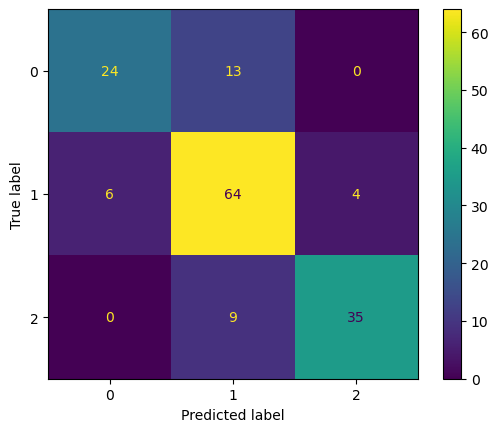

In [143]:
# outcome from using log_norm transformation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(train_y, y_sim_train)
cm_display = ConfusionMatrixDisplay(cm).plot()

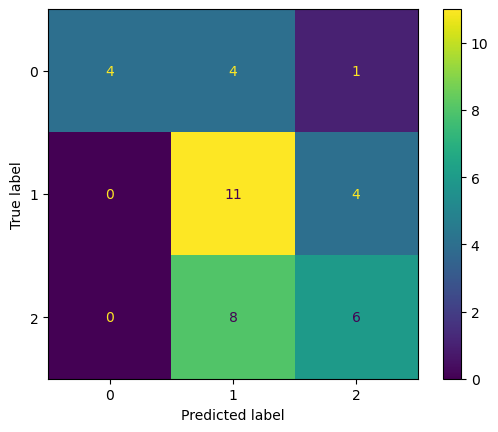

In [144]:
# outcome from using log_norm transformation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(test_y, y_sim)
cm_display = ConfusionMatrixDisplay(cm).plot()

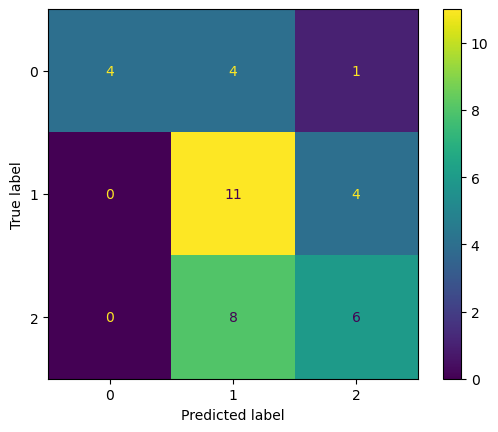

In [145]:
# outcome from using log_norm transformation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(test_y, y_sim)
cm_display = ConfusionMatrixDisplay(cm).plot()

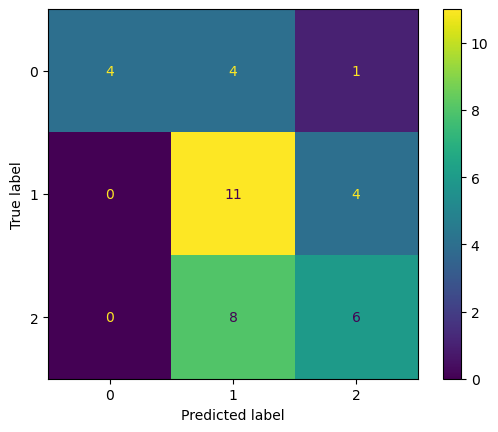

In [165]:
# outcome from using log_norm transformation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm_test = confusion_matrix(test_y, y_pred)
cm_display = ConfusionMatrixDisplay(cm_test).plot()

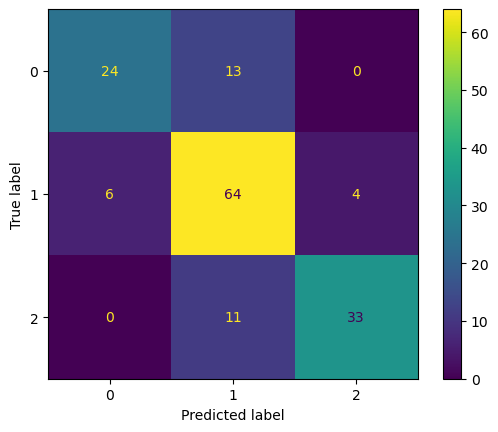

In [166]:
# outcome from using log_norm transformation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm_train = confusion_matrix(train_y, y_pred_train)
cm_display = ConfusionMatrixDisplay(cm_train).plot()

Analyse (1) independent latent function, and (2) latent parameter functions

In [148]:
model.eval()

with torch.no_grad():
    latent_dist = model.variational_strategy.latent_dist
    lmc_coefficients = model.variational_strategy.lmc_coefficients
    lmc_coefficients = lmc_coefficients.cpu().detach()

ilf_lower, ilf_upper = latent_dist.confidence_region()
ilf_mean = latent_dist.mean
ilf_lower, ilf_upper, ilf_mean = ilf_lower.cpu(), ilf_upper.cpu(), ilf_mean.cpu()

In [149]:
def eigen(lmc_coefficients, norm=True, round=5):
    
    V_mat = lmc_coefficients.T @ lmc_coefficients
    if norm:
        V_mat = torch.divide(V_mat, torch.norm(V_mat, dim=-1).unsqueeze(-1))
    V_eigval, V_eigvec = np.linalg.eig(V_mat)
    idx_sort = np.argsort(V_eigval)[::-1]
    V_eigval, V_eigvec = V_eigval[idx_sort], V_eigvec[:,idx_sort]
    V_eigval, V_eigvec = np.round(V_eigval, round), np.round(V_eigvec, round)

    return V_eigval, V_eigvec

In [150]:
V_mat = lmc_coefficients.T @ lmc_coefficients
V_eigval, V_eigvec = np.linalg.eig(V_mat)

In [151]:
outcome_l = [
    '{COBRA\_WIN}', 
    '{SURVIVED}',
    '{VIPER\_WIN}', 
]

In [196]:
labels = [
    r"$f_{COBRA\_WIN}$", 
    r"$f_{SURVIVED}$", 
    r"$f_{VIPER\_WIN}$",     
]
eigval, eigvec = eigen(lmc_coefficients, norm=True)
sns.scatterplot(eigvec[:,0], eigvec[:,1], hue=labels)
fig.tight_layout()

IndexError: index 1 is out of bounds for axis 1 with size 1

In [197]:
inputs = [
    'viper_launch_range',
    'viper_briefed_evasion_range',
    'cobra_launch_range',
    'cobra_briefed_evasion_range',
]

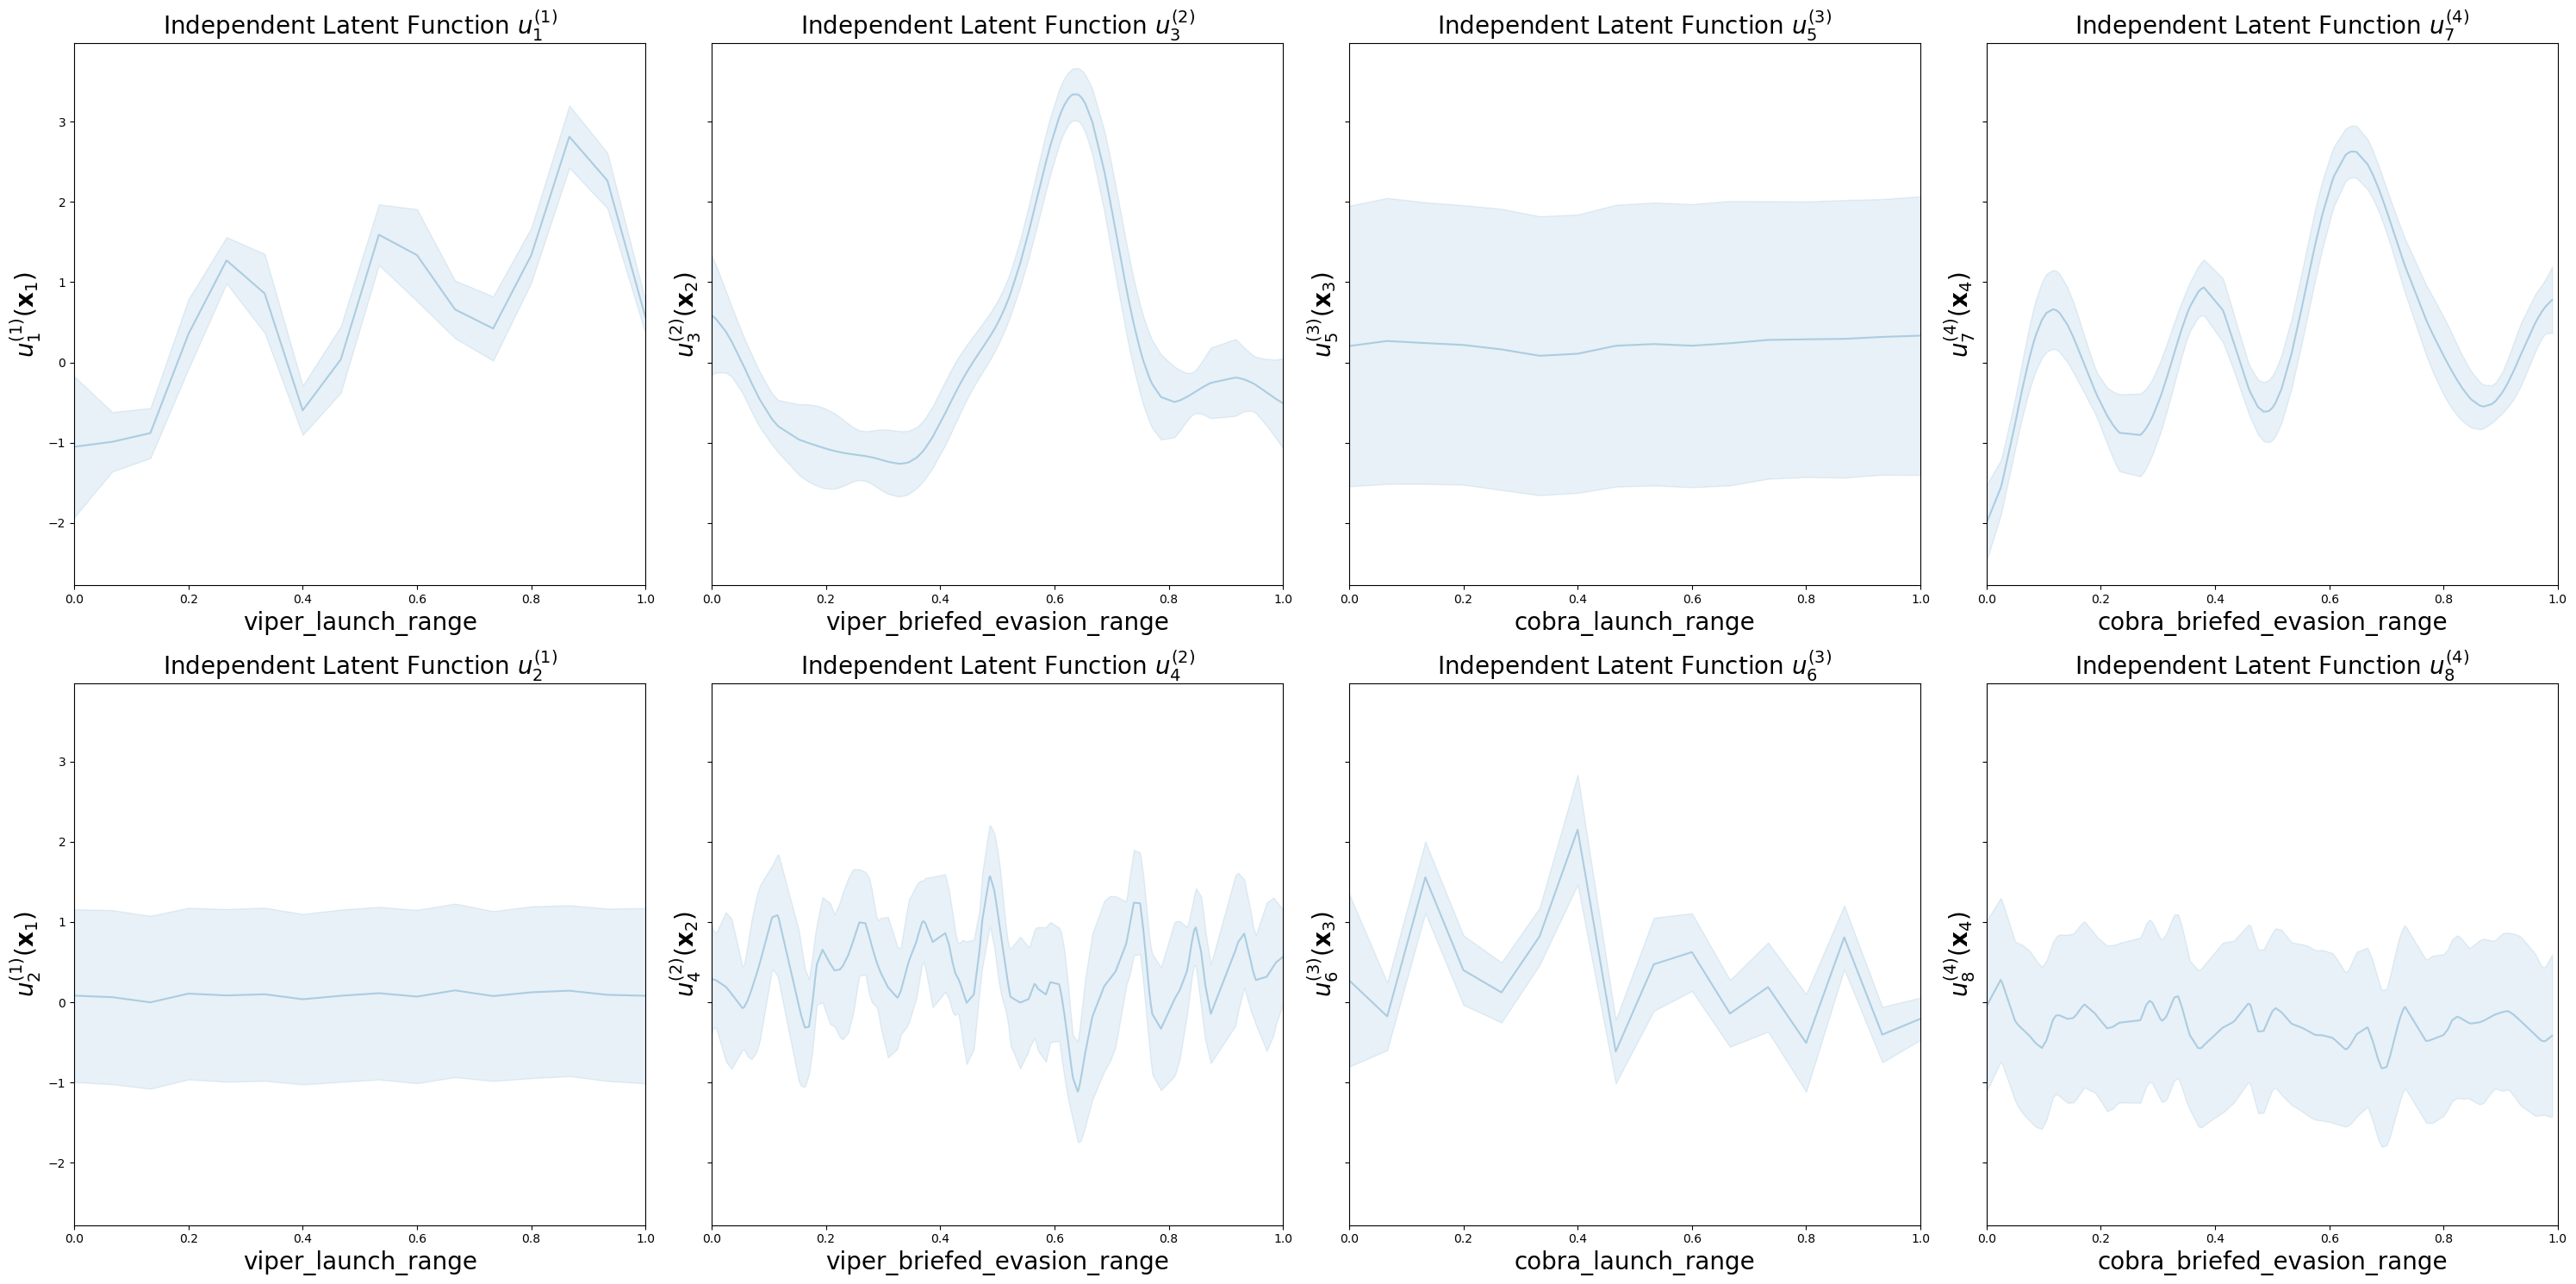

In [198]:
# visualize the result
input_dim = train_x.size(-1)
num_latents = ilf_mean.size(0)
n_categories = 2

# visualize the result
fig, func = plt.subplots(nrows=n_categories, ncols=input_dim, figsize=(30, 15), sharey=True)
# x="x"

for j in range(input_dim):
    row = 0
    for i in range(num_latents):
        if j == active_dims[i][0]:
            indices = np.argsort(train_x[:,j])
            line, = func[row,j].plot(train_x[indices,j], ilf_mean[i,indices], alpha=0.3)
            func[row,j].fill_between(
                train_x[indices,j], ilf_lower[i,indices],
                ilf_upper[i,indices], alpha=0.1, color=line.get_color()
            )
            # func[row,j].set_xlabel(f"${{\mathbf{{x}}_{{{j+1}}}}}$", fontdict={'fontsize':20})
            func[row,j].set_xlabel(inputs[j], fontdict={'fontsize':20})
            func[row,j].set_ylabel(f"${{u_{{{i+1}}}^{{({j+1})}}(\mathbf{{x}}_{{{j+1}}})}}$", fontdict={'fontsize':20})
            func[row,j].set_title(f"Independent Latent Function ${{u_{{{i+1}}}^{{({j+1})}}}}$", fontdict={'fontsize':20})
            func[row,j].set_xlim([0.,1.])
            row += 1

fig.tight_layout()

In [199]:
def compute_f_pd_p(x, input_dim, output_d, ilf, lmc, active_dims, get_indices=True):
    active_dims = np.array(active_dims)
    lpf_idx, _ = np.where(active_dims==[input_dim])
    indices = np.argsort(x[:,input_dim])
    f_pd = (ilf.T[:,lpf_idx] @ lmc[lpf_idx,:])[indices,output_d]
    if get_indices:
        return indices, f_pd
    else:
        return f_pd

Text(0.0, -9.5, 'scotts_pi score: 0.2696')

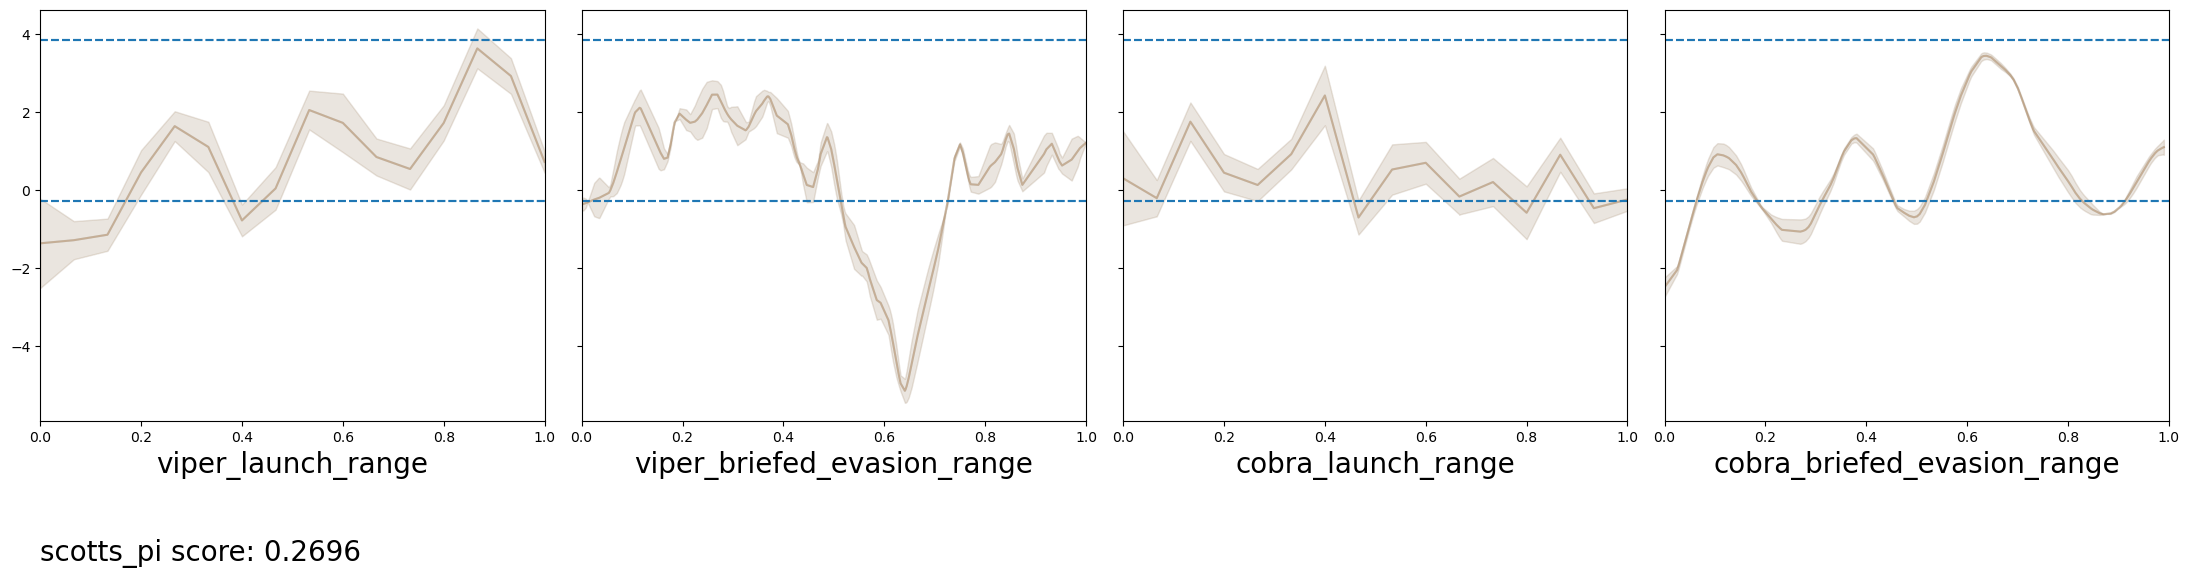

In [212]:
# visualize the result
input_dim = train_x.size(-1)
num_latents = ilf_mean.size(0)
n_categories = 2

# visualize the result
fig, func = plt.subplots(ncols=input_dim, figsize=(22, 5), sharey=True)
# x="x"

for j in range(input_dim):
    for i in range(num_latents):
        if j == active_dims[i][0]:
            indices = np.argsort(train_x[:,j])
            indices, f_mean = compute_f_pd_p(train_x, j, 0, ilf_mean, lmc_coefficients, active_dims)
            _, f_lower = compute_f_pd_p(train_x, j, 0, ilf_lower, lmc_coefficients, active_dims)
            _, f_upper = compute_f_pd_p(train_x, j, 0, ilf_upper, lmc_coefficients, active_dims)
            line, = func[j].plot(train_x[indices,j], f_mean, alpha=0.3)
            func[j].fill_between(
                train_x[indices,j], f_lower,
                f_upper, alpha=0.1, color=line.get_color()
            )
            c_line = func[j].hlines(mu_cutpoints[0], 0, 1, ls="--")
            # func[j].fill_between(
            #     train_x[indices,j], 
            #     mu_cutpoints[0] - sd_cutpoints[0],
            #     mu_cutpoints[0] + sd_cutpoints[0], 
            #     alpha=0.1, color=c_line.get_color()
            # )
            func[j].hlines(mu_cutpoints[1], 0, 1, ls="--")
            # func[j].fill_between(
            #     train_x[indices,j], 
            #     mu_cutpoints[1] - sd_cutpoints[1],
            #     mu_cutpoints[1] + sd_cutpoints[1], 
            #     alpha=0.1, color=c_line.get_color()
            # )
            func[j].set_xlabel(f"${{\mathbf{{x}}_{{{j+1}}}}}$", fontdict={'fontsize':20})
            func[j].set_xlabel(inputs[j], fontdict={'fontsize':20})
            # func[j].set_ylabel(f"${{f_{{{outcome_l[row]}}}^{{({j+1})}}(\mathbf{{x}}_{{{j+1}}})}}$", fontdict={'fontsize':20})
            # func[j].set_title(f"Raw Latent Parameter Function ${{f_{{{outcome_l[row]}}}^{{({j+1})}}}}$", fontdict={'fontsize':20})
            func[j].set_xlim([0.,1.])
            # row += 1

fig.tight_layout()
score = scotts_pi(cm_test, weight_type="unweighted")
func[0].annotate(f"scotts_pi score: {score}", (0.0, -9.5), fontsize=20, annotation_clip=False)

In [202]:
# dyanmic alpha by abs(f)
# normalise f_alpha = (abs(f) - abs(f.max())) / (abs(f.max()) - abs(f.min()))

In [203]:
# requires predicting on new data without updating posterior
# train_x[compute_f_pd(train_x, 2, i, ilf_mean, lmc_coefficients, active_dims)[0], 2] 

In [204]:
score = scotts_pi(cm_test, weight_type="quadratic")
print("scotts_pi:", score)

scotts_pi: 0.2696
